# Bounding Box Prediction

$b_x=\sigma(t_x)+c_x$  

$b_y=\sigma(t_y)+c_y$  

$b_\omega=p_\omega e^{t_\omega}$  

$b_h=p_h e^{t_h}$

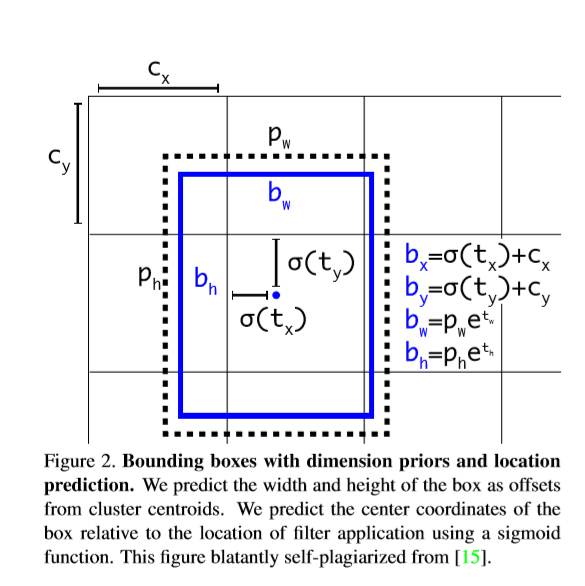

# Object Score

YOLOv3 predicts an objectness score for each bounding box using logistic regression. 
* This should be 1 if the bounding box prior overlaps a ground truth object.
* If bounding box prior is not the best but does overlap a ground truth object by more than some threshold,ignore the prediction.
* if a bounding box prior is not assigned to a ground truth object and not ignored it incurs no loss for coordinate or class predictions, only objectness

# Feature Extractor 

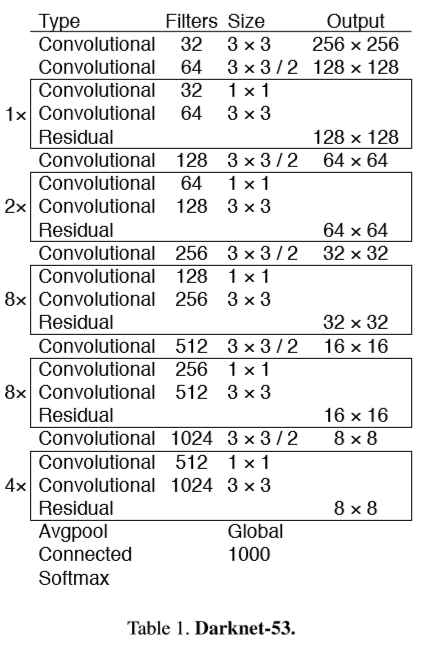

# predict bounding boxes across different feature maps scales

* 5 max poolings, for default input size (416,416) this is (13,13)
* 4 max poolings, for default input size (416,416) this is (26,26)
* 3 max poolings, for default input size (416,416) this is (32,32)
* For default input image size (416,416), there are $(13\times13+26\times26+32\times32)\times num\_anchors$ bounding box detectors in YOLOV3. 
* The smaller feature maps （with larger receptive field） usually predicts bounding boxes refers to big anchors
* The YOLOv3 upsamples the final feature maps (13,13) to (26,26) and (32,32) respectively, and concatenates them with feature maps of shadow convolutional layers(contains more detail features) to predict small objects

# Code 

In [1]:
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.models import Model
from yolov3_body import yolo_body

## yolo loss calculation

In [2]:
def yolo_head(feats,anchors,num_classes,input_shape):
    '''
    This function convert the feature maps of three different convolutional layer of yolov3_body to bounding box parameters.
    The transformation of bounding box are shown in above picture
    feats:       4-dims tensor, shape = (m,grid_h,grid_w,num_anchors*(5+num_classes))
    anchors:     2-dims array,  shape = (num_anchors,2)
    input_shape: 2-dims tensor, shape = (2,)
    '''
    
    num_anchors = len(anchors)
    grid_shape = K.shape(feats)[1:3]
    
    # This is for broadcasting -> (batch_size, height, width, num_anchors, box_params)
    anchors_tensor = K.reshape(K.constant(anchors),shape=[1,1,1,num_anchors,2])
    feats = K.reshape(feats,[-1,grid_shape[0],grid_shape[1],num_anchors,num_classes+5])
    
    # Create the Offset matrics
    # Consider the np.meshgrid to understand the following code
    grid_y = K.arange(0,grid_shape[0])
    grid_y = K.expand_dims(grid_y,axis=1)
    grid_y = K.tile(grid_y,[1,grid_shape[1]])
    
    grid_x = K.arange(0,grid_shape[1])
    grid_x = K.expand_dims(grid_x,axis=[0])
    grid_x = K.tile(grid_y,[grid_shape[0],1])
    
    grid = K.stack([grid_x,grid_y],axis=-1)
    grid = K.expand_dims(grid_x,axis=2) # This is for broadcasting
    grid = K.expand_dims(grid_x,axis=0) # This is for broadcasting
    grid = K.cast(grid,K.dtype(feats))
    
    # apply the Offset matrics to the feats
    box_xy = (K.sigmoid(feats[...,:2])+grid)/K.cast(grid_shape[::-1],K.dtype(feats))
    box_wh = K.exp(feats[...,2:4])*anchors_tensor/K.cast(input_shape[::-1,K.dtype(feats)])
    
    return grid, feats, box_xy, box_wh

def box_iou(b1,b2):
    '''Return iou tensor
    This function is later used in yolo_loss function to decide which bounding box detectors can be ignored
    Parameters
    b1:tensor,shape=(i1,...,iN,4) xywh
    b2:tensor,shape=(j,4),xywh
    '''
    #  Expand dim to apply broadcasting.
    b1 = K.expand_dims(axis=-2)
    b1_xy = b1[...,0:2]
    b1_wh = b1[...,2:4]
    b1_wh_half = b1_wh/2.0
    b1_mins = b1_xy-b1_wh_half
    b1_maxes = b1_xy+b1_wh_half

    b2_xy = b2[...,0:2]
    b2_wh = b2[...,2:4]
    b2_wh_half = b2_wh/2.0
    b2_mins = b2_xy-b2_wh_half
    b2_maxes = b2_xy+b2_wh_half

    intersect_mins = K.maximum(b1_mins,b2_mins)
    intersect_maxes = K.minimum(b1_maxes,b2_maxes)
    intersect_wh = K.maximum(intersect_maxes-intersect_mins,0)
    intersect_area = intersect_wh[...,0]*intersect_wh[...,1]
    b1_area = b1_wh[...,0]*b1_wh[...,1]
    b2_area = b2_wh[...,0]*b2_wh[...,1]
    iou = intersect_area/(b1_area+b2_area-intersect_area)
    return iou

def yolo_loss(args,anchors,num_classes,ignore_thresh=0.5):
    '''
        yolo_outputs:list of tensor, the output of three different convolutional layer of yolo_body,
        shape=[batch_size,grid_h,grid_w,num_anchors,(5+num_classes)] (the xywh are relative value calculate by the equations above).
        
        y_true: list of tensors represent the true value, shape = [batch_size,grid_h,grid_w,num_anchors,5+num_classes] 
        (the xywh are normalized by the size of input image).
        
        anchors:2-dims array,shape=(N,2) 
        
        num_classes:integer
        
        ignore_thres:float, the iou threshold whether to ignore object confidence loss
    '''
    num_layers = len(anchors)//3
    yolo_outputs = args[:num_layers]
    y_true = args[num_layers:] 
    anchor_mask = [[6,7,8],[3,4,5],[0,1,2]] if num_layers==3 else [[3,4,5],[1,2,3]]
    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3]*32,dtype=K.dtype(y_true[0]))
    grid_shape = [K.cast(K.shape(yolo_outputs[l])[1:3],dtype=K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0
    mf = K.cast(K.shape(yolo_outputs[0])[0],K.dtype(yolo_outputs[0]))
    
    for l in range(num_layers):
    
        object_mask = y_true[l][...,4:5] #[batch_size,grid_y,grid_x,num_anchors,1]

        # calculate the xywh loss
        grid, raw_pred, pred_xy, pred_wh = yolo_head(yolo_outputs[l],anchors[anchor_mask[l]],input_shape)
        raw_true_xy = y_true[l][...,:2]*grid_shape[l][::-1]-grid
        raw_true_wh = K.log(y_true[l][...,2:4]*input_shape[::-1]/anchors[anchor_mask[l]])
        raw_true_wh = K.switch(object_mask,raw_true_wh,K.zeros_like(raw_true_wh))
        box_loss_scale = 1+(1-y_true[l][...,2:3]*y_true[l][...,3:4]) # better for understanding
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy,raw_pred[...,0:2],from_logits=True)
        wh_loss = object_mask * box_loss_scale * K.square(raw_true_wh-raw_pred[...,2:4])
        xy_loss = K.sum(xy_loss)/mf
        wh_loss = K.sum(wh_loss)/mf
        loss +=xy_loss
        loss +=wh_loss
        
        # calculate the confidence loss
        # if the bounding box detector overlap a ground truth object by more than some threashold, 
        # the prediction should be ignored when calculate the confidence loss
        pred_box = K.concatenate([pred_xy,pred_wh]) # used for iou calculation
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]),size=1,dynamic_size=True)
        object_mask_bool = K.cast(object_mask,'bool')
        def loop_body(b,ignore_mask):
            true_box = tf.boolean_mask(y_true[l][b,...,0:4],object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b,...,0:4],true_box)#[grid_y,grid_x,num_anchors,j]
            best_iou = K.max(iou,axis=-1) #[grid_y,grid_x,num_anchors]
            ignore_mask = ignore_mask.write(b,K.cast(best_iou<ignore_thresh,K.dtype(true_box)))#list of tensor-[grid_y,grid_x,num_anchors]
            return b+1,ignore_mask
        _, ignore_mask = K.control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])#list of tensor-[grid_y,grid_x,num_anchors]
        ignore_mask = ignore_mask.stack()#[batch_size,grid_y,grid_x,num_anchors]
        ignore_mask = K.expand_dims(ignore_mask,axis=-1) #[batch_size,grid_y,grid_x,num_anchors,1]
        confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
        (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
        confidence_loss = K.sum(confidence_loss) / mf
        loss += confidence_loss
        
        true_class_probs = y_true[l][...,5:]
        class_loss = object_mask*K.binary_crossentropy(true_class_probs,raw_pred[...,5:],from_logits=True)
        class_loss = K.sum(class_loss)/mf
        loss += class_loss
        
    return loss

## YOLOv3 Creation